In [45]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [35]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('cork_property_prices*.csv')], ignore_index = True)
df = df.drop_duplicates(subset='listing_id', keep='first') # Dedup on listing_id and keep first record.
# Clean data
df['cost'] = df['cost'].str.replace(",","") # Remove commas in cost column
df = df[(df.cost.str.isnumeric() == True)] # Remove rows with alpha characters
df['cost'] = pd.to_numeric(df['cost'])
df['cost'] = df['cost']/1000 # In K units

# Create an ordinal equivalent of BER
df['ber'] = pd.Categorical(df['ber'])
df['ber_ord'] = df.ber.cat.codes

# 1-hot the categoricals
loc_cat = pd.get_dummies(df.location, prefix = 'loc')
type_cat = pd.get_dummies(df.property_type, prefix = 'typ')
#df = pd.concat([df,y], axis=1)
df = pd.concat([df,loc_cat,type_cat], axis=1)
df.shape
df


,listing_id,location,address,beds,bathrooms,cost,num_pics,property_type,ber,ber_ord,...,loc_douglas,loc_glasheen,loc_grange,loc_model-farm-road,loc_wilton,typ_Detached House,typ_End of Terrace House,typ_Semi-Detached House,typ_Terraced House,typ_Townhouse
0,2549894,douglas,Kincora| South Douglas Road| Douglas| Co. Cork,3,1,259.0,24,Semi-Detached House,NaN,-1,...,1,0,0,0,0,0,0,1,0,0
1,2255069,douglas,Denmead| 38 Hettyfield Park| Douglas| Co. Cork,4,4,795.0,23,Detached House,D1,7,...,1,0,0,0,0,1,0,0,0,0
2,2217312,douglas,80 Yewlands| Maryborough Woods| Douglas| Co. Cork,3,3,310.0,8,Terraced House,C1,4,...,1,0,0,0,0,0,0,0,1,0
3,2548380,douglas,115 Greenhills Court| South Douglas Road| Doug...,3,2,245.0,33,Terraced House,C3,6,...,1,0,0,0,0,0,0,0,1,0
4,2255031,douglas,10 Springbrook| Donnybrook| Douglas| Co. Cork,3,3,249.0,16,Semi-Detached House,D1,7,...,1,0,0,0,0,0,0,1,0,0
5,2154356,douglas,Clogheen| Hettyfield Park| Douglas| Co. Cork,5,4,725.0,33,Detached House,D1,7,...,1,0,0,0,0,1,0,0,0,0
6,2069030,douglas,8 Lislee Road| Maryborough Estate| Douglas| Co...,4,2,489.0,12,Detached House,D2,8,...,1,0,0,0,0,1,0,0,0,0
7,2125026,douglas,Emeralda| 12 Ballincurrig Park| Douglas| Co. Cork,4,1,425.0,18,Semi-Detached House,D2,8,...,1,0,0,0,0,0,0,1,0,0
8,2526196,douglas,10 Rathmore Lawn| Douglas| Co. Cork,3,1,375.0,10,Semi-Detached House,E1,9,...,1,0,0,0,0,0,0,1,0,0
9,2563871,douglas,16 Inchvale Close| Shamrock Lawn| Douglas| Co....,3,1,240.0,14,Semi-Detached House,_G,12,...,1,0,0,0,0,0,0,1,0,0


In [36]:
# 75:25 train:test split.
from sklearn.model_selection import train_test_split
df = df.drop(['listing_id','location','address','property_type','ber'], axis=1)
train, test = train_test_split(df, test_size=0.2)
x = train.drop('cost', axis=1)
y = train.cost

In [37]:
import xgboost as xgb
xgr = xgb.XGBRegressor(random_state=42, n_jobs=8)
xgr.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

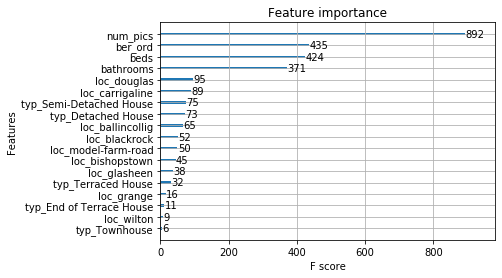

In [39]:
xgb.plot_importance(xgr)

In [44]:
preds = xgr.predict(test.drop('cost',axis=1))
test.cost - preds
rmse = np.sqrt(mean_squared_error(test.cost, preds))
print("RMSE: %f" % (rmse))
print("MSE: ", mean_squared_error(test.cost, preds))
print("Mean Absolute Error: %f" % mean_absolute_error(test.cost,preds))
print("R2: ", r2_score(test.cost,preds))

RMSE: 189.943334
MSE:  36078.47005560738
R2:  0.37737935369637754


RMSE: 119.797372
